# How much for that Chevrolet? - Predicting car prices with ML

`categories: ML fundamentals, k-nearest neighbors, missing-data imputation, model validation`

<p align='center'>    
    <img src="imgs/car_negotiation.jpg" width=600 height=550 />
</p>    

<p style="text-align: center;">(image taken from goautocity.com)</p>

## Project's intro

In this project, we'll practice with one the simplest machine learning algorithms: k-nearest neighbors (**kNN** form now on).<br/>
This algorithm can be used for both regression and classification tasks. In our case, the goal is to **evaluate how well a kNN model can predict the prices of cars models using one or more car features**, i.e. a regression application.

### Evaluate model performances

The metric we will use to compare the performances of our model in different conditions is the average root mean square error (**avg RMSE**) together with the root mean square error stadard deviation (**std RMSE**), calculated with [k-fold cross validation](https://machinelearningmastery.com/k-fold-cross-validation/). It's unfortunate that we use the same symbol, k, for two different concepts, but hopefully context will resolve any ambiguity.

In more explicit terms, for a certain choice of cars features and k (no. of nearest neighbors), we will:

- divide the dataset in 10 parts (10-fold cross validation);
- use a tenth of the dataset as a test set, and the rest as a training set;
- calculate the RMSE of the model in predicting the car prices of the test set examples;
- repeat the previous two steps using a new tenth of the dataset as test set;
- calculate the mean and standard deviation of the ten RMSEs: this is our model's quality measure for this particular choice of features.

### Summary of results

In short, the results are that either a kNN algorithm is not ideal for this specific task, or the dataset is not large enough to adequately span the car features space.<br/>
The best performance is obtained with a 3 features multivariate model and using 6 or 7 nearest neighbors.

### Modules, libraries and project-wide settings

In [1]:
# data analysis libraries
import matplotlib.pyplot as plt
import missingno
import numpy as np
import os
import pandas as pd
import seaborn as sns

# ML functionalitites
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score

# plot settings
plt.style.use('seaborn-darkgrid')  # pyplot style
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

# notebook display settings
pd.options.display.max_rows = 40

## Dataset presentation

You can download the data used in this project [here](https://archive.ics.uci.edu/ml/datasets/automobile).

In order to accomplish our goal, we're going to use a dataset taken from the UCI machine learning repository.<br/>
Each of the 205 car models in the dataset is described with **25 features**, some of them categorical (e.g. car maker, fuel-type etc.), other numeric (e.g. curb-weight, length etc.). Each car model is labelled with its price. You can read more detailed info in the `Data Set Information` paragraph of the download page.

Let's read in the data and sneak a peek, so we start familiarizing with them:

In [2]:
col_names = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 
             'body-style','drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 
             'curb-weight', 'engine-type','num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 
             'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

path = os.path.join(os.curdir, 'datasets', 'imports-85.data')
cars = pd.read_csv(path, names=col_names)
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


The last column, `price`, is our target variable.<br/>
We immediately notice that some missing data are encoded as `?`. If nans are encoded like this in all columns, the types of columns with missing values will all be strings (or objects, in pandas lingo).<br/>
Let's check:

In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

Yep, that seems to be the case. It's time to perform some data cleaning. 

## Data cleaning

### - Type conversion

In the next cell, we will replace each `?` with the more appropriate numpy nan, select only the 15 numeric columns of the dataset, and finally convert them to numeric types.

In [4]:
cars.replace('?', np.nan, inplace=True)

numeric_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height',
                'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-rate',
                'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

cars = cars[numeric_cols].astype('float')

### - Dealing with missing values: imputation

As a first step, we'll drop all the examples with missing label, i.e. price, then print a summary of the missing values.

In [5]:
cars.dropna(axis=0, subset=['price'], inplace=True)
cars.reset_index(drop=True, inplace=True)

# summary of missing values
print(f'Missing values (out of {len(cars)} examples):')
cars.isnull().sum()

Missing values (out of 201 examples):


normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

We use the missingno module to visualize the distribution of missing values in a pretty way:

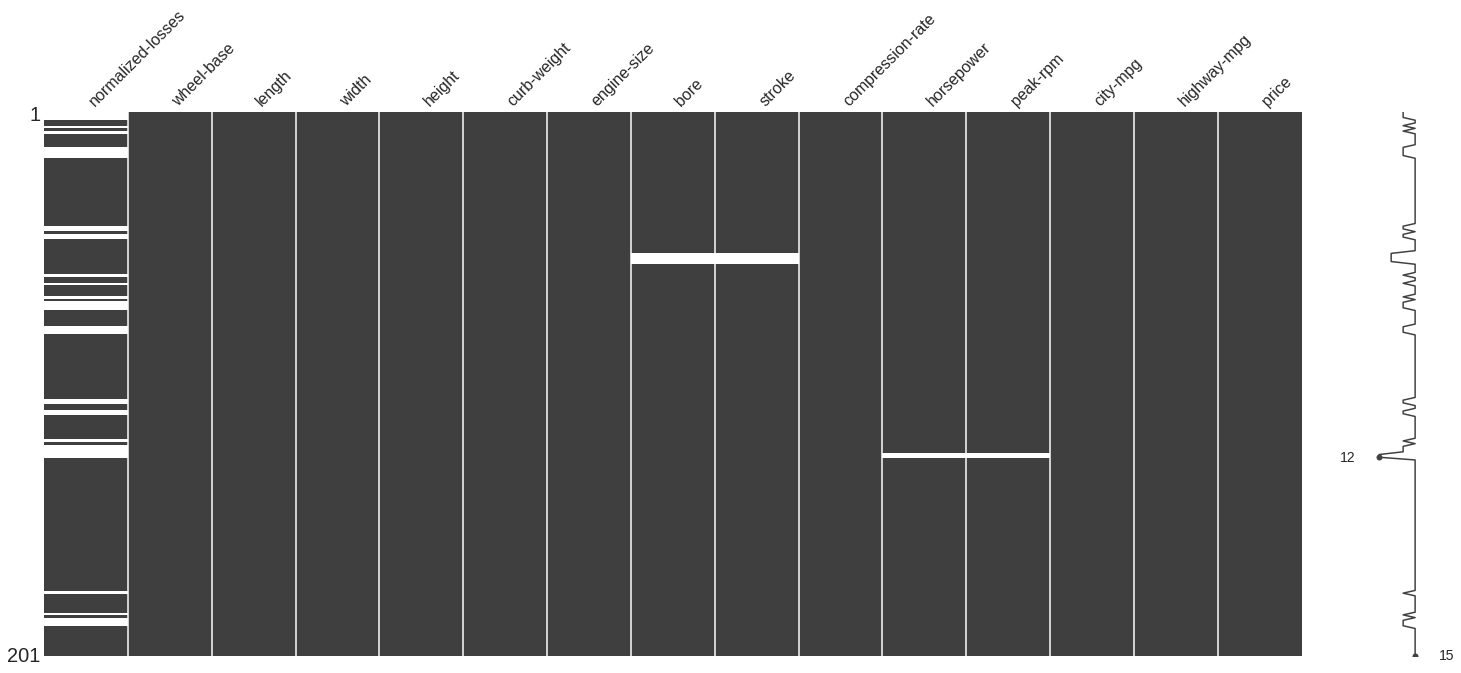

In [6]:
missingno.matrix(cars)

plt.show()

The columns `bore` and `stroke` have 4 missing values (about 2% of the examples), while `horsepower` and `peak-rpm` have 2 (about 1%). We have no easy way to impute these values; given their relative small number, our decision is to drop these rows from the dataset altogether:

In [7]:
cars.dropna(axis=0, subset=['bore', 'stroke', 'horsepower', 'peak-rpm'], inplace=True)
cars.reset_index(drop=True, inplace=True)

We are left with **195 examples**.<br/>
Moving forward, the column `normalized-loss` is more problematic:

In [8]:
print(round(cars['normalized-losses'].isnull().sum() / len(cars) * 100, 1))

17.9


With 18% of missing values, we cannot afford dropping the corresponding rows (we would lose too much information). The possible approaches are:

    1. drop the column (and lose a potential good predictor of the prize);
    2. try to impute the missing values.

We will go for the second option and **try two different imputation techniques**:

    2.1 replace the missing values with the column mean;
    2.2 use a kNN model to predict the missing values.

The first approach is the easiest, but it's also quite risky: this way, data are easily biased and the distribution of data is modified. Unfortunately, while the [dataset documentation](https://archive.ics.uci.edu/ml/datasets/automobile) specifies that the losses are "normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc...)", information are not precise enough to identify these classes. As a result, we cannot use the group averages, as [this article](https://towardsdatascience.com/substituting-missing-data-with-the-group-average-why-its-good-to-be-cautious-d64bead7a029) for example suggests.

Because there's no way to tell in advance which technique will work best, we will try both of them.<br/>

The function corresponding to 2.2 is written in the next cell and will be used as the first step in the modelling sections.

In [9]:
def imputation_through_kNN(df_with_nans: pd.DataFrame) -> None:
    
    knn = KNeighborsRegressor(5, algorithm='auto')
    
    # create training set, labels series and predictors for missing values
    mask_nans = df_with_nans['normalized-losses'].isnull()  # select rows with missing normalized-losses
    train = df_with_nans[~mask_nans].drop(['normalized-losses', 'price'], axis=1)
    labels = df_with_nans[~mask_nans]['normalized-losses']
    predictors = df_with_nans[mask_nans].drop(['normalized-losses', 'price'], axis=1)
    
    # fit the model and predict missing values
    knn.fit(train, labels)
    predicted_normalized_losses = knn.predict(predictors)
    
    # substitute nans with predicted values
    df_with_nans.loc[mask_nans, 'normalized-losses'] = predicted_normalized_losses
    
    return

### -  Z-score standardization

It's a good practice to normalize the numeric features in some way before starting the training of the model.<br/>
The z-score standardization carries out the following mapping:

$$x_{i}^j \rightarrow \frac{x_{i}^j - \mu_{i}}{\sigma_{i}},$$

where the mapping is applied to the i-th feature of the j-th example; $\mu_{i}$ and $\sigma_{i}$ are the mean and standard deviation of the i-th feature over the whole dataset.<br/>
Let's do it:

In [10]:
cars_no_price = cars.iloc[:, 0:14].copy()
# performing z-score standardization on all but the price column
cars_no_price = (cars_no_price - cars_no_price.mean()) / cars_no_price.std()
cars.iloc[:, 0:14] = cars_no_price

## Model performance evaluation

Now for the meaty part of the project: kNN model performance evaluation.<br/>

As a first step, we must impute the value of the `normalized-losses` column, though.<br/>
As we anticipated, we use the column mean and a kNN regression estimate.<br/>
This will lead to two new columns: `norm_losses_mean` and `norm_losses_knn`.

In [11]:
norm_losses = cars['normalized-losses'].copy()
# (see 2.2 imputation section)
imputation_through_kNN(cars)
cars.rename({'normalized-losses': 'norm_losses_knn'}, axis=1, inplace=True)
# (see 2.1 imputation section)
cars['norm_losses_mean'] = norm_losses.fillna(norm_losses.mean())

## - Univariate models

The function defined in the next cell will train and validate the model for us, using a particular column (`train_col` parameter) as predicting feature.

In [12]:
def train_and_test_univariate(data: pd.DataFrame, train_col: str, target_col: str, k: int) -> tuple:
    '''
    Train and validate an univariate kNN model using 10-fold cross validation.
    Uses scikit-learn kNN implementation and cross_val_score function for cross validation.
    
        Parameters:
            data: the dataframe representing the dataset with no missing values and numeric values
                  (i.e. already completely cleaned)
            train_col: the single column to use as a predicting feature
            target_col: the dataframe column to use as a target
            k: no. of nearest neighbors (model hyperparameter)
            
        Returns:
            a 2-items tuple containing the avg RMSE and the std RMSE, i.e. model performance metric
    '''
    
    # instantiate a kNN model    
    knn = KNeighborsRegressor(k, algorithm='auto')
    # instantiate a k-fold cross validator (using 10 folds)
    kfold = KFold(10, shuffle=True, random_state=1)
    # evaluate performance of the model (negative MSE for each dataset splitting) 
    scores = cross_val_score(knn, data[[train_col]], data[target_col], 
                             scoring="neg_mean_squared_error", cv=kfold)
    rmses = np.sqrt(np.abs(scores)) # from MSE to RMSE
    
    return (np.mean(rmses), np.std(rmses))    

Let's first use the default number of nearest neighbors (k=5) and each single dataset column to understand which car features are most promising to estimate its price.

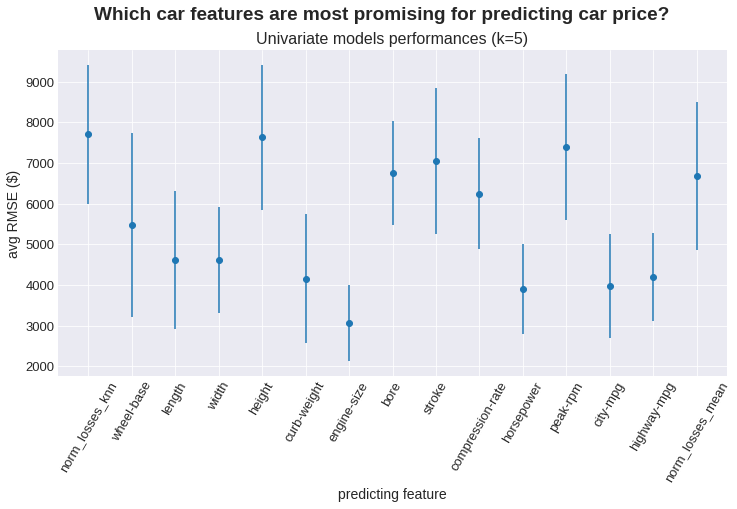

In [13]:
univ_avg_rmse = []
univ_std_rmse = []

train_cols = cars.drop('price', 1).columns

for train_col in train_cols:
        performance = train_and_test_univariate(cars, train_col, 'price', k=5)
        univ_avg_rmse.append(performance[0])
        univ_std_rmse.append(performance[1])        
        
# plot results
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.errorbar(train_cols, univ_avg_rmse, yerr=univ_std_rmse, fmt='o')

fig.suptitle('Which car features are most promising for predicting car price?', fontsize=19, weight='bold')
ax.set_title('Univariate models performances (k=5)',  fontsize=16)
ax.set_xlabel('predicting feature')
ax.set_ylabel('avg RMSE ($)')
plt.xticks(rotation=60)

plt.show()

The best univariate model for k=5 is the one which uses the **engine size** as a predictor.<br/>
Nonetheless, even in this case, the average error is in the order of 3000 dollars with about 1000 of standard deviation.<br/>
This means that, using our dataset, the engine size can predict the car price with an average error as low as \\$2000 and as high as \\$4000, in most cases. Considering we're talking about cars (and not, for example, planes...:-)) these results tell us that we cannot be satisfied with just a one-dimensional model.

Among the "least worst" predictors, we find `horsepower`, `city-mpg` (miles per gallon) and `highway-mpg`.<br/>
As a final observation before the next step, we also note that our `normalized-losses` columns, whose missing values we imputed in two different ways, are among the worst predictors...

So, a natural question after these results is: what about varying k and see if the performances improve?<br/>
Let's do it in the next paragraph.

### Univariate models with varying k

In [14]:
k_values = [1, 3, 5, 7,  9]
train_cols = cars.drop('price', 1).columns

# setting up dictionaries with rmses and rmse std deviations
avg_rmse = {train_col: {} for train_col in train_cols}
std_rmse = {train_col: {} for train_col in train_cols}

for train_col in train_cols:
    for k in k_values:
        performance = train_and_test_univariate(cars, train_col, 'price', k)
        avg_rmse[train_col][k] = performance[0]
        std_rmse[train_col][k] = performance[1]

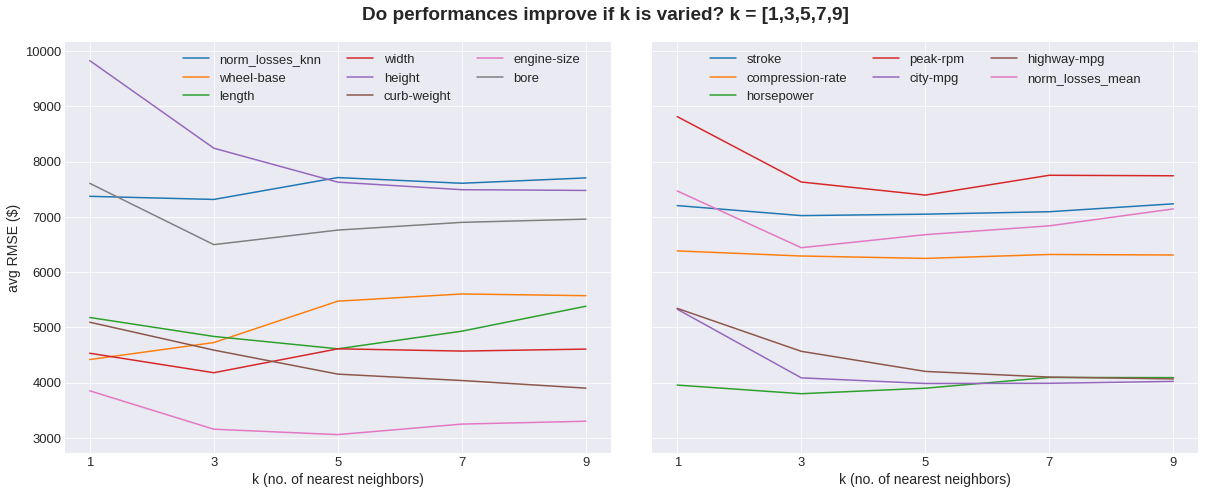

In [15]:
# plot results
fig, axs = plt.subplots(1, 2, figsize=(17, 7), sharey=True)

for train_col in train_cols[:8]:
    axs[0].errorbar(avg_rmse[train_col].keys(), avg_rmse[train_col].values())
    axs[0].legend(train_cols[:8], loc='upper center', bbox_to_anchor=(0.58, 1),
                  ncol=3, fancybox=True, shadow=True)
    
for train_col in train_cols[8:]:
    axs[1].errorbar(avg_rmse[train_col].keys(), avg_rmse[train_col].values())        
    axs[1].legend(train_cols[8:], loc='upper center', bbox_to_anchor=(0.5, 1.0),
                  ncol=3, fancybox=True, shadow=True)

fig.suptitle('Do performances improve if k is varied? k = [1,3,5,7,9]', fontsize=19, weight='bold') 
axs[0].set_ylabel('avg RMSE ($)')    
axs[0].set_xlabel('k (no. of nearest neighbors)')
axs[1].set_xlabel('k (no. of nearest neighbors)')
axs[0].set_xticks(k_values)
axs[1].set_xticks(k_values)
        
plt.tight_layout()        
plt.show()    

(We have split the chart in two for readability.)

**Observations**:
- **engine-size** is again the overall single best performing feature; it has minimum average error for k=5.
- for some columns, performances seem to improve significantly until k reaches 5, then the improvement is hardy noticeable;
- for **curb-weight** (left chart) and **horsepower**, **city-mpg**, **highway-mpg** (right chart) the average errors "converge" at \\$4000 for k=9. These are the next best performing single features. May they be good multivariate predictors, taken together?
- we confirm our imputed normalized-losses are among the worst price predictors.

We haven't reported error standard deviations in the previous charts for readability, but let's take the five most promising features and plot their performances again, with std RMSE:

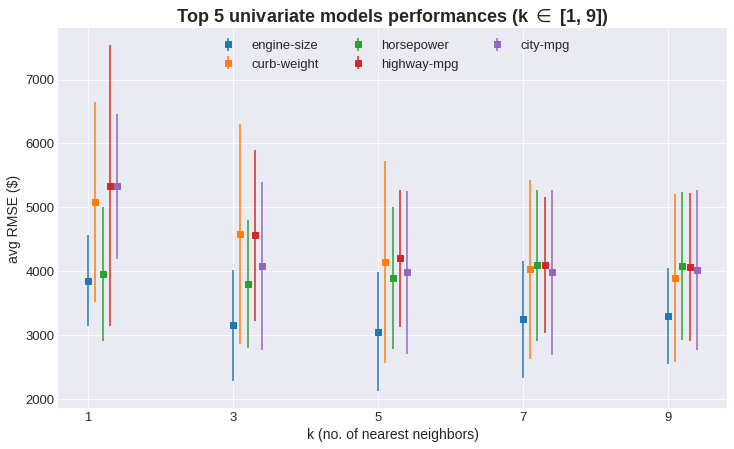

In [16]:
promising_features = ['engine-size', 'curb-weight', 'horsepower', 'highway-mpg', 'city-mpg']

fig, ax = plt.subplots(1, 1, figsize=(12, 7))

for i, feature in enumerate(promising_features):
    ax.errorbar([k + 0.1*i for k in avg_rmse[feature].keys()], avg_rmse[feature].values(), 
                 yerr=std_rmse[feature].values(), fmt='s')        
    ax.legend(promising_features, loc='upper center', bbox_to_anchor=(0.5, 1.0),
              ncol=3, fancybox=True, shadow=True)
    
ax.set_ylabel('avg RMSE ($)')    
ax.set_xlabel('k (no. of nearest neighbors)')
ax.set_title('Top 5 univariate models performances (k $\in$ [1, 9])', weight='bold')
ax.set_xticks(k_values)

plt.show()

(For each k, we slightly shifted the bars to avoid superposition, but they all refer to the same k.)

As we already noticed, the performances improve as 5 or more nearest neighbors are used. This is true also for the standard deviation, a proxy of the model variance: predictions become more consistent across different datasets.<br/>
Nonetheless, we must be honest: these results are not so exciting. Each single feature have an average error of several thousand dollars and only the engine size has error variations of few hundreds dollars. The other predictors have error standard deviations of more than \\$1000, even in the best case (k=7 or 9).
Our hope is that combining all these features, the predictive power of our model will improve considerably.

## - Multivariate models

In order to train and test a multivariate model, we have to slightly modify the function from the previous paragraph, so that it can accept a list of features instead of just one.

In [17]:
def train_and_test_multivariate(data: pd.DataFrame, train_cols: list, target_col: str, k: int) -> tuple:
    
    # instantiate a kNN model    
    knn = KNeighborsRegressor(k, algorithm='auto')
    # instantiate a k-fold cross validator (using 10 folds)
    kfold = KFold(10, shuffle=True, random_state=1)
    # evaluate performance of the model (negative MSE for each split of data) 
    scores = cross_val_score(knn, data[train_cols], data[target_col], 
                             scoring="neg_mean_squared_error", cv=kfold)
    rmses = np.sqrt(np.abs(scores)) # from MSE to RMSE
    
    return (np.mean(rmses), np.std(rmses))    

We will now use k=5 (the default value) and various combinations of the 5 top performing features found in the previous section.

More precisely, we're going to use the following features selection:

- **top 2**: engine-size and horsepower
- **top 3**: engine-size, horsepower and city-mpg
- **top 4**: engine-size, horsepower, city-mpg and curb-weight
- **top 5**: engine-size, horsepower, city-mpg, curb-weight and highway-mpg

In [18]:
# train and evaluate models

top_5_predictors = ['engine-size', 'horsepower', 'city-mpg', 'curb-weight', 'highway-mpg']
multiv_avg_rmse= {}
multiv_std_rmse = {}

for i in range(4):
    performance = train_and_test_multivariate(cars, top_5_predictors[:i+2], 'price', k=5)
    multiv_avg_rmse['top ' + str(i+2)] = performance[0]
    multiv_std_rmse['top ' + str(i+2)] = performance[1]

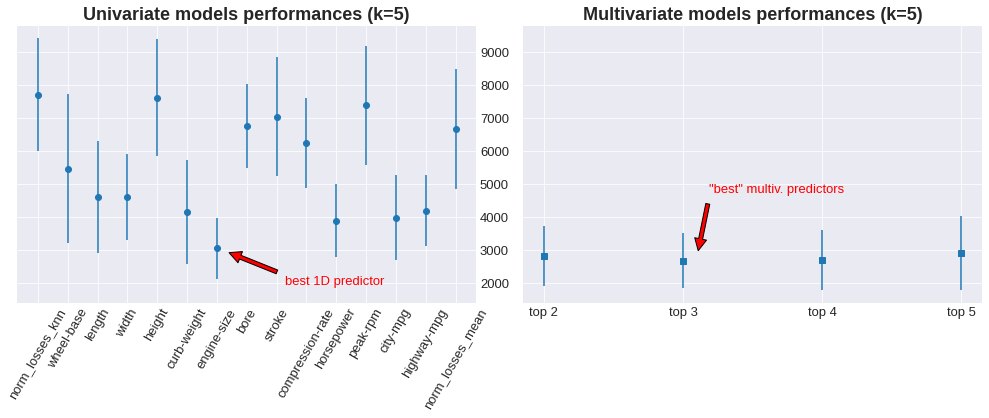

In [19]:
# plot results

fig, (axl, axr) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axl.errorbar(train_cols, univ_avg_rmse, yerr=univ_std_rmse, fmt='o')
axr.errorbar(multiv_avg_rmse.keys(), multiv_avg_rmse.values(), multiv_std_rmse.values(), fmt='s')

# plot customization + annotations
axl.set_xticks(range(15))
axl.set_xticklabels(train_cols, rotation=60)
axl.yaxis.set_label_position("right")
axl.yaxis.tick_right()
axl.set_title('Univariate models performances (k=5)', weight='bold')
axr.set_title('Multivariate models performances (k=5)', weight='bold')

axl.annotate('best 1D predictor', xy=(6.2, 3000),  xycoords='data',
             xytext=(0.8, 0.1), textcoords='axes fraction',
             arrowprops=dict(facecolor='red', shrink=0.1), color='red',
             horizontalalignment='right', verticalalignment='top')

axr.annotate('"best" multiv. predictors', xy=(1.1, 2800),  xycoords='data',
             xytext=(0.7, 0.43), textcoords='axes fraction',
             arrowprops=dict(facecolor='red', shrink=0.1), color='red',
             horizontalalignment='right', verticalalignment='top')

plt.tight_layout()
plt.show()

For ease of comparison, on the left chart we've reported the univariate models performances obtained in the previous paragraph. Both cases are for k=5 and the y axis scale (average RMSE in $) is shared.

We observe a slight improvement in performances, although not so remarkable. Strictly speaking, the best performing multivariate model is the top 3, using **engine-size**, **horsepower** and **city-mpg** as predictors. However, both top 2 and top 4 have very similar average RMSE and standard deviation.<br/>
In short, it seems that using at least two features is advisable, but we didn't find clear evidence that using three or four really improves the model.

Let's see if varying the k parameter will shed some light on these issues...

## Hyperparameter tuning

Let's now use the top 2, 3 and 4 features and tune the k hyperparameter. 

In [20]:
features = ['engine-size', 'horsepower', 'city-mpg', 'curb-weight']

# dicitonary with tran and test results
k_tuning_avg_rmse = {}
k_tuning_std_rmse = {}

# train and evaluate the model with 2, 3 and 4 top features
# and k from 1 to 26 
for i in range(3):
    rmse = []
    std_rmse = []
    for k in range(1, 26):
        performance = train_and_test_multivariate(cars, features[:i+2], 'price', k)
        rmse.append(performance[0])
        std_rmse.append(performance[1])
    k_tuning_avg_rmse['top ' + str(i+2)] = rmse
    k_tuning_std_rmse['top ' + str(i+2)] = std_rmse   

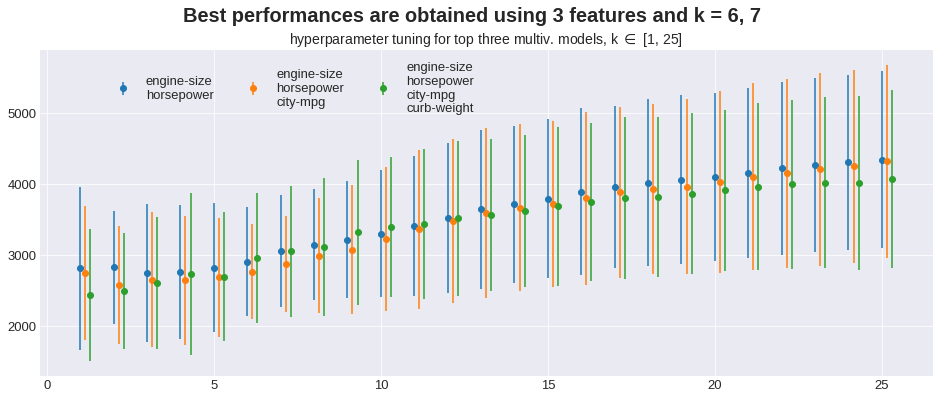

In [22]:
# plot results

fig, ax = plt.subplots(1, 1, figsize=(16, 6))

labels = ['engine-size\nhorsepower', 'engine-size\nhorsepower\ncity-mpg',
          'engine-size\nhorsepower\ncity-mpg\ncurb-weight']

for i in range(3):
    ax.errorbar([k + i * 0.15 for k in range(1, 26)], 
                k_tuning_avg_rmse['top ' + str(i+2)], 
                k_tuning_std_rmse['top ' + str(i+2)], fmt='o')
    ax.legend(labels, bbox_to_anchor=(0.5, 1.0), ncol=3)
    
fig.suptitle('Best performances are obtained using 3 features and k = 6, 7', weight='bold', fontsize=20)
ax.set_title('hyperparameter tuning for top three multiv. models, k $\in$ [1, 25]', fontsize=14)    
    
plt.show()   

We clearly see that using more than 8 nearest neighbors somehow "confuses" the algoritm: the performances consistently worsen.<br/>
On the other hand, the algorithm seems less sensitive to the space dimensionality, although 3 features is to be considered the sweet spot.

Our hopes of obtaining remarkably better performances by combining the most promising single features and varying k were not confirmed.<br/> 
The **best overall performance** is:

$$\$2766 \pm 671\quad(k=6)$$

## Conclusions

In this project, we have evaluated how well a kNN algorithm would have predicted the prices of car models by using one or more of its features.<br/>
The dataset used, after cleaning, consisted of 195 car models with 14 numerical features.

The results are the following:
- **engine-size** is the best single price predictor;
- using a multivariate model with **engine-size**, **horsepower** and **city-mpg** slightly improve the performances;
- the best perfomance is obtained with the previous three features combined and k = 6.

In any case, the model doesn't perform very well, because average errors are still of the order of \\$2000 and the variance is quite high (at least \\$600).<br/>
Therefore, the results can be interpreted in two ways: either the kNN algorithm is not ideal for this problem, or the dataset is not big enough to adequately span the space of car features. 